# 大类资产历史表现

每类资产都用一个指数代表，即假设被动式、买入持有的投资方式，所有股息和利息都再投资，没有交易成本和其他费用，也没有任何额外收益。

C:\Users\HST\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\HST\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\HST\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\HST\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0, flags=flags)


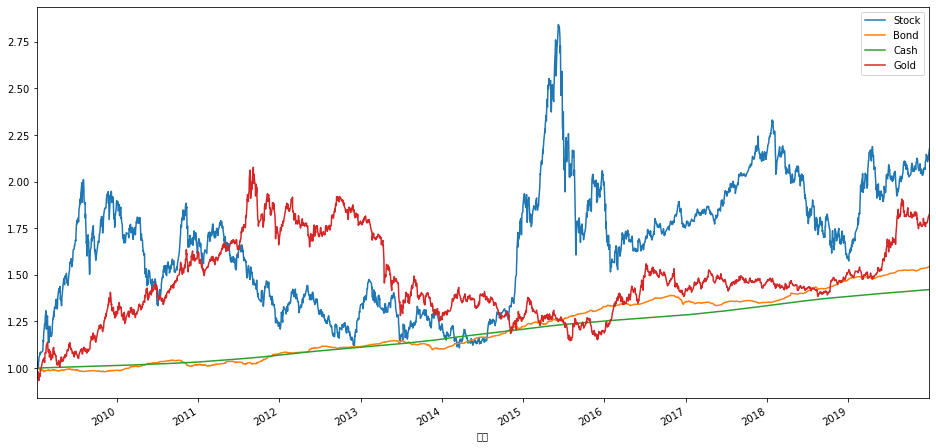

In [1]:
# 读取资产价格数据
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

AssetPrice = pd.read_csv("./csv/AssetPrice0.csv", index_col=0, header=0, parse_dates=True, infer_datetime_format=True, encoding="utf-8")
AssetPrice = AssetPrice.rename(columns={"000300.SH": "Stock", "H11001": "Bond", "H11025": "Cash", "AUCI.SHF": "Gold"})
# AssetPrice = AssetPrice.rename(columns={"000300.SH": "CN_Stock", "H11001": "Bond", "H11025": "Cash", "AUCI.SHF": "Gold", ".GSPC.NYSE": "US_Stock"})
# AssetPrice.pop("HSI.HK")
# AssetPrice = AssetPrice.rename(columns={"000300.SH": "CN_Stock", "H11001": "Bond", "H11025": "Cash", "AUCI.SHF": "Gold", ".GSPC.NYSE": "US_Stock", "HSI.HK": "HK_Stock"})
# AssetPrice = AssetPrice.rename(columns={"000300.SH": "CN_Big_Stock", "000905.SH": "CN_Mid_Stock", "000852.SH": "CN_Small_Stock", "H11006": "T_Bond", "H11007": "F_Bond", "H11008": "C_Bond", "H11025": "Cash", "AUCI.SHF": "Gold", ".GSPC.NYSE": "US_Stock", "HSI.HK": "HK_Stock"})
(AssetPrice / AssetPrice.iloc[0]).plot(figsize=(16, 8));

# 年度收益，TODO

In [2]:
# 历史表现
# 年化收益率
Return = (AssetPrice.iloc[-1] / AssetPrice.iloc[0]) ** (365 / (AssetPrice.index[-1] - AssetPrice.index[0]).days) - 1
# 协方差矩阵
Cov = AssetPrice.pct_change().cov() * 252
# 相关系数矩阵
Volatility = pd.Series(np.diag(Cov.values)**0.5, index=Cov.index)
Rho = pd.DataFrame((Cov.values / Volatility.values).T / Volatility.values, index=Cov.index, columns=Cov.columns)

# Formatters = [lambda x: '{0: .2f}%'.format(x*100)]*2 + [lambda x: '{0: .2f}'.format(x)]*7
Summary = pd.DataFrame({"Annual Return": Return, "Volatility": Volatility, "Sharpe Ratio(rf=0)": Return / Volatility})
display(Summary.merge(Rho, left_index=True, right_index=True))

,Annual Return,Volatility,Sharpe Ratio(rf=0),Stock,Bond,Cash,Gold
Stock,0.073278,0.241582,0.303324,1.000000,-0.014142,0.010884,0.072357
Bond,0.040356,0.014729,2.739881,-0.014142,1.000000,0.149490,0.013026
Cash,0.032490,0.001726,18.824372,0.010884,0.149490,1.000000,0.034685
Gold,0.056331,0.157193,0.358355,0.072357,0.013026,0.034685,1.000000


大类资产的历史表现和时间区间相关性很大，而且承担风险并不总能得到相应补偿。（如果总能得到补偿，也就不叫风险了）

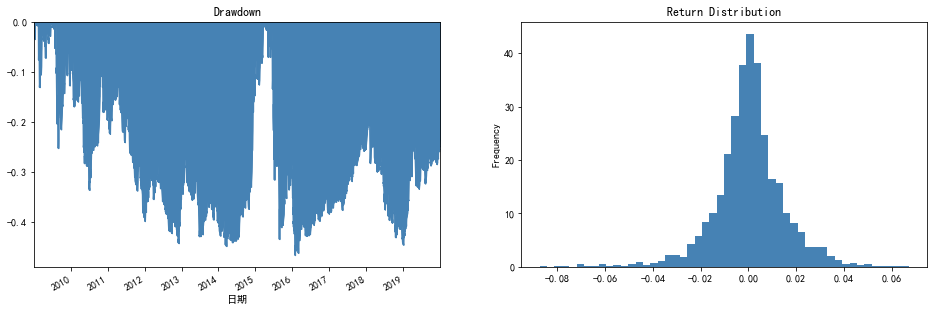

In [3]:
# 单资产分析
import QuantStudio.api as QS

TargetAsset = "Stock"
# 名义收益率和经通胀调整的实际收益率，TODO

import matplotlib.pyplot as plt
Fig, Axes = plt.subplots(1,2,figsize=(16, 5))
# 回撤
Drawdown = pd.Series(QS.Tools.Strategy.calcDrawdown(AssetPrice[TargetAsset].values)[0], index=AssetPrice.index)
Drawdown.plot(kind="area", title="Drawdown", ax=Axes[0], color="steelblue");
# 收益率分布
AssetPrice[TargetAsset].pct_change().plot(kind="hist", bins=50, density=True, title="Return Distribution", ax=Axes[1], color="steelblue");

# 资本市场假设

资本市场假设（CMAs）一般包括资产的预期收益、风险以及相关性，其作为战略资产配置的输入，期限需和 SAA 的期限相匹配。

# 历史数据法

历史数据法假设资产的风险和收益在长期将收敛到均值，即资产的风险和收益都是平稳的时间序列，因此根据足够长时期的资产表现历史数据，预测资产未来足够长时期的风险收益，历史数据法得到的结果应该是无偏且一致的。

实际应用中历史数据法的问题：
1. 很多大类资产历史数据年限不长，尤其是国内市场。数据不足导致样本均值的方差变大，样本均值可能偏离总体均值的真实值很远；或者说在历史数据的时间序列内，观察不到资产收益和风险的长期均值。用历史数据法预测未来收益风险，至少需要 10 年的数据（\cite{Qutke:2018}）。
2. 历史无法代表未来，即便有足够长的历史数据，使用历史均值预测未来都可能失效，即风险和收益长期收敛到均值的假设可能不成立。
3. 投资者的投资年限可能不长，这要求资产的风险和收益必须以更快的速度收敛到均值。

历史数据法在预测股票市场预期收益率和相关性时并不可靠，但在预测股票市场波动性时较为可靠；历史数据法在预测债券市场预期收益率和波动性时效果较好。

# 结构法

## 简单结构法

\cite{Lustig:2016}

简单结构法直观地将预期收益结构分解为：债券收益率、股票风险溢价以及现金资产贴现。

投资者根据自己的本币选择长期债券（比如 10 年期国债）的收益率作为未来债券预期收益率很好的预测指标，但在恶性通胀或者通缩时期，两者之间的相关性可能就不存在了。

对于现金收益率，简单的可以用长期债券收益率减去 1% 得到。更简单准确的方法使用当前短期利率（或者 1 年期票据利率）作为下一年的现金资产收益率。

对于股票的风险溢价，4% 是一个比较合理的估计值。

对于波动率和相关性的估计，一般使用各类资产有史以来（自上一次经济或市场发生结构性变化以来）的历史月度收益波动率来估算资产的风险水平，相关性的估计类似。

简单结构法在估算债券的预期收益率时比较直观和稳定，但在估算股票预期收益率上过于简单粗放。

# Regime-Switch 分析法

## 美林时钟分析法

美林时钟分析框架最早由美林证券提出，通过对经济增长和通胀两个指标的分析，将经济周期划分为衰退、复苏、过热、滞涨四个阶段，然后计算每个阶段下各个资产的风险收益指标以及资产间的相关性，结合宏观研究得到未来每个阶段出现的概率，最后对各个指标按照各阶段概率加权平均作为预期指标值。

经典的美林时钟状态划分：
* 衰退期：经济下行，产出缺口减少、通胀下行；货币政策趋松，债券的表现最突出，大类资产表现：债券 > 现金 > 股票 > 商品；
* 复苏期：经济上行，产出缺口增加、通胀下行；经济转好，企业盈利改善，股票获得超额收益，大类资产表现：股票 > 债券 > 现金 > 商品；
* 过热器：经济上行，产出缺口增加、通胀上行；通胀上行增加了现金的持有成本，加息的可能性降低了债券的吸引力，商品将受益于通胀的上行，大类资产表现：商品 > 股票 > 现金 / 债券
* 滞胀期：经济下行，产出缺口减少、通胀上行；经济下行对企业盈利形成拖累，对股票构成负面影响，债券的吸引力提升，大类资产表现：现金 > 债券 > 商品 / 股票

美林时钟在历史数据年限不足的情况下同样无能为力，但由于其对历史时间序列做了精细化的处理，并结合了对未来经济状态的预测，美林时钟不再依赖于均值回归的假设，同时对于预测的未来时间长度也没有限制。

![美林时钟分析框架](.\images\美林时钟分析框架.jpg)

经济增长可以用 GDP 的产出缺口代表，通胀可用 CPI 代表。

## 一般的 Regime-Switch 方法

美林时钟法根据经济增长和通胀两个经济指标将经济划分为四个状态，Regime-Based 分析法则是在美林时钟法基础上的延伸和扩展，可引入更多的指标自主划分经济和市场状态，然后计算每个经济状态下各个资产的风险收益特征以及相关性，结合宏观研究，预测未来一段时间每个经济状态出现的概率，以此综合估计大类资产预期风险收益和相关性。完美的状态划分需要满足：
* 每个状态有清晰的经济学含义；
* 每个状态下各大类资产有相对稳定的风险收益表现。

# 参考文献

[<a id="cit-Qutke:2018" href="#call-Qutke:2018">况客研究:2018</a>] 况客研究, FOF投资的量化分析, 中国金融出版社, 2018.

[<a id="cit-Lustig:2016" href="#call-Lustig:2016">Lustig:2016</a>] Yoram Lustig 著, 孙静, 郑志勇, 李韵 译, 资产配置投资实践, 电子工业出版社, 2016.